# Variational Auto-Encoder

Implementing a VAE in TensorFlow. Doing this to understand VAEs better so I can then figure out VRNNs and then VRADA.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from mnist import MNIST # pip install --user python-mnist
from urllib.parse import urlparse
from urllib.request import urlretrieve
%matplotlib inline
layers = tf.contrib.layers
framework = tf.contrib.framework

Download and load the dataset.

In [2]:
files = [
    "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
    "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
    "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
    "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"
]

def download(url, fn, force=False):
    if force or not os.path.exists(fn):
        urlretrieve(url, fn)
        print("Downloaded", fn)
    else:
        print("Already downloaded", fn)

for f in files:
    download(f, os.path.basename(urlparse(f).path))

Already downloaded train-images-idx3-ubyte.gz
Already downloaded train-labels-idx1-ubyte.gz
Already downloaded t10k-images-idx3-ubyte.gz
Already downloaded t10k-labels-idx1-ubyte.gz


In [3]:
mndata = MNIST('.', return_type='numpy', gz=True)
train_images, train_labels = mndata.load_training()
test_images, test_labels = mndata.load_testing()
assert train_images.shape[0] == train_labels.shape[0]
assert test_images.shape[0] == test_labels.shape[0]

Reshape the 784x1 images to 28x28 images and normalize.

In [4]:
train_images = (train_images.reshape(-1,28,28,1).astype(np.float32) - 128.0) / 128.0
test_images = (test_images.reshape(-1,28,28,1).astype(np.float32) - 128.0) / 128.0

Visualize digits.

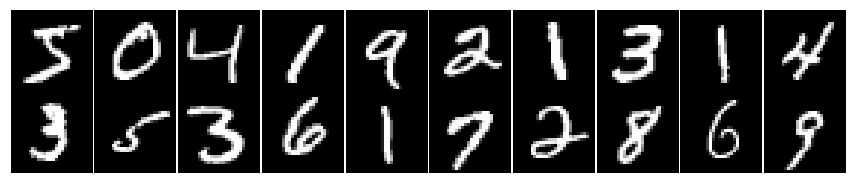

In [5]:
def show(images, num=20, cols=10):
    fig = plt.figure(figsize=(15,3))
    fig.subplots_adjust(wspace=0, hspace=0)
    for i in range(num):
        ax = fig.add_subplot(np.ceil(num/cols), cols, i+1)
        ax.grid(False); ax.set_yticks([]); ax.set_xticks([]); plt.axis('off')
        plt.imshow((128*np.squeeze(images[i]) + 128).astype(np.uint8), cmap='gray')
    plt.show()

show(train_images)

Not-so-pretty code to feed data to TensorFlow.

In [6]:
class IteratorInitializerHook(tf.train.SessionRunHook):
    """Hook to initialise data iterator after Session is created.
    https://medium.com/onfido-tech/higher-level-apis-in-tensorflow-67bfb602e6c0"""
    def __init__(self):
        super(IteratorInitializerHook, self).__init__()
        self.iter_init_func = None

    def after_create_session(self, sess, coord):
        """Initialize the iterator after the session has been created."""
        self.iter_init_func(sess)

def _get_train_input_fn(features, labels, batch_size):
    iter_init_hook = IteratorInitializerHook()
    
    def train_input_fn():
        # Input images using placeholders to reduce memory usage
        features_placeholder = tf.placeholder(features.dtype, features.shape)
        labels_placeholder = tf.placeholder(labels.dtype, labels.shape)
        dataset = tf.data.Dataset.from_tensor_slices((features_placeholder, labels_placeholder))
        dataset = dataset.repeat().shuffle(5000).batch(batch_size)
        iterator = dataset.make_initializable_iterator()
        next_image_batch, next_label_batch = iterator.get_next()
        
        # Need to initialize iterator after creating a session in the estimator
        iter_init_hook.iter_init_func = lambda sess: sess.run(
            iterator.initializer, feed_dict={features_placeholder: features,
                                          labels_placeholder: labels})
        
        return next_image_batch
    return train_input_fn, iter_init_hook

## VAEs

For explanations of VAEs and code examples:
 - https://towardsdatascience.com/teaching-a-variational-autoencoder-vae-to-draw-mnist-characters-978675c95776  ([notebook](https://github.com/FelixMohr/Deep-learning-with-Python/blob/master/VAE.ipynb))
 - https://jmetzen.github.io/2015-11-27/vae.html ([notebook](https://github.com/jmetzen/jmetzen.github.com/blob/source/content/notebooks/vae.ipynb))
 - https://jaan.io/what-is-variational-autoencoder-vae-tutorial/ ([code](https://github.com/altosaar/variational-autoencoder/blob/master/vae.py))
 - https://arxiv.org/abs/1606.05908 ([code](https://github.com/cdoersch/vae_tutorial))

Explanation of why we can use L2 loss rather than log-likelihood (which is in the papers about VAEs):
 - https://stats.stackexchange.com/a/288453
 
We'll try it twice, following two different people's implementations. Though, we'll use the same networks for both. I chose to go with Felix Mohr's since they were convolutional rather than purely fully connected.

In [7]:
leaky_relu = lambda net: tf.nn.leaky_relu(net, alpha=0.3)

def encoder(x, keep_prob, n_latent, reuse=None):
    with tf.variable_scope("encoder", reuse=reuse), \
         framework.arg_scope([layers.conv2d], num_outputs=64, kernel_size=4,
                             padding='same', activation_fn=leaky_relu):
        n  = tf.reshape(x, shape=[-1, 28, 28, 1])
        n  = layers.conv2d(n, stride=2)
        n  = tf.nn.dropout(n, keep_prob)
        n  = layers.conv2d(n, stride=2)
        n  = tf.nn.dropout(n, keep_prob)
        n  = layers.conv2d(n, stride=1)
        n  = tf.nn.dropout(n, keep_prob)
        n  = layers.flatten(n)
        mn = tf.layers.dense(n, units=n_latent)
        sd      = 0.5 * tf.layers.dense(n, units=n_latent)            
        epsilon = tf.random_normal(tf.stack([tf.shape(n)[0], n_latent])) 
        z  = mn + tf.multiply(epsilon, tf.exp(sd))
        return z, mn, sd

def decoder(sampled_z, keep_prob, reuse=None):
    with tf.variable_scope("decoder", reuse=reuse), \
         framework.arg_scope([layers.conv2d_transpose], num_outputs=64, kernel_size=4,
                             padding='same', activation_fn=tf.nn.relu):
        n = tf.layers.dense(sampled_z, units=24, activation=leaky_relu)
        n = tf.layers.dense(n, units=24*2 + 1, activation=leaky_relu)
        n = tf.reshape(n, [-1, 7, 7, 1]) # 24*2+1 = 49
        n = layers.conv2d_transpose(n, stride=2)
        n = tf.nn.dropout(n, keep_prob)
        n = layers.conv2d_transpose(n, stride=1)
        n = tf.nn.dropout(n, keep_prob)
        n = layers.conv2d_transpose(n, stride=1)
        n = layers.flatten(n)
        n = tf.layers.dense(n, units=28*28, activation=tf.nn.tanh)
        img = tf.reshape(n, shape=[-1, 28, 28, 1])
        return img

### Version based on Felix Mohr's code (seems simpler)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into vae-model/model.ckpt.
Iteration 0 - Loss: 670.33484 ImgLoss: 670.24225 LatentLoss: 0.09255758 Mu: -0.023124095 Sigma: -0.008373474


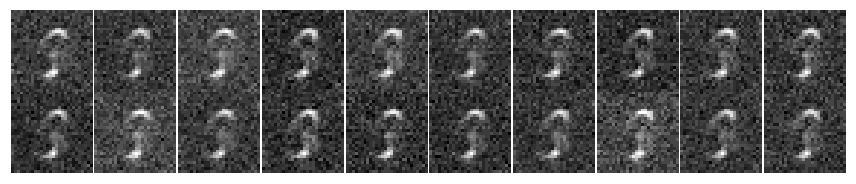

Iteration 200 - Loss: 138.32895 ImgLoss: 125.37459 LatentLoss: 12.954362 Mu: -0.15688565 Sigma: -1.1076717


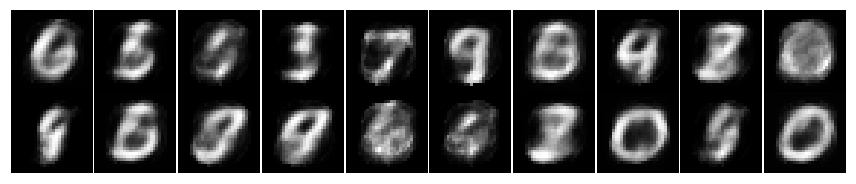

INFO:tensorflow:Saving checkpoints for 400 into vae-model/model.ckpt.
Iteration 400 - Loss: 90.06113 ImgLoss: 73.95236 LatentLoss: 16.108759 Mu: -0.101733245 Sigma: -1.4855372


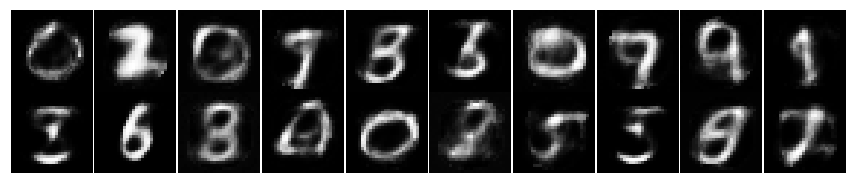

Iteration 600 - Loss: 90.35409 ImgLoss: 73.137695 LatentLoss: 17.216389 Mu: -0.0053740144 Sigma: -1.6521515


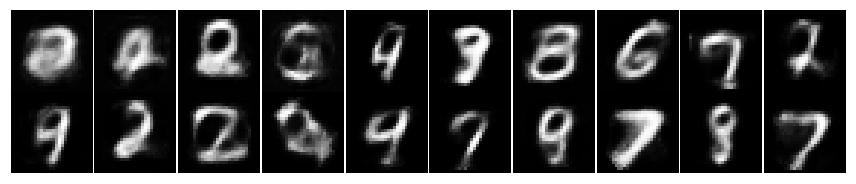

INFO:tensorflow:Saving checkpoints for 800 into vae-model/model.ckpt.
Iteration 800 - Loss: 89.71471 ImgLoss: 71.09907 LatentLoss: 18.615644 Mu: -0.09562087 Sigma: -1.8162454


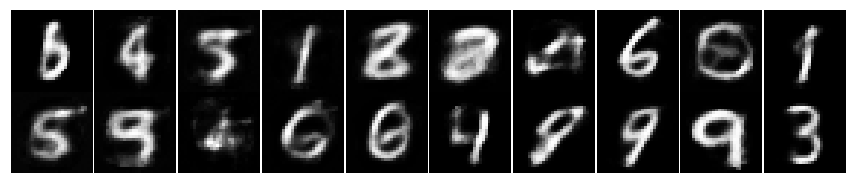

Iteration 1000 - Loss: 88.73329 ImgLoss: 70.63117 LatentLoss: 18.102112 Mu: 0.078733504 Sigma: -1.7888409


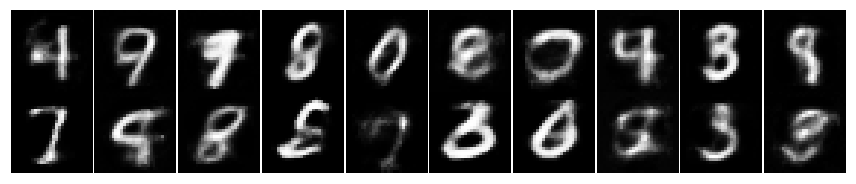

INFO:tensorflow:Saving checkpoints for 1001 into vae-model/model.ckpt.


In [8]:
def denormalize(image):
    """ Take TensorFlow tensor and get a 8-bit (0-255) image again """
    return tf.cast(128*image + 128, tf.uint8)

def train(features, labels, n_latent=10, batch_size=64, num_steps=1000, num_eval=20,
         model_dir="vae-model", log_dir="vae-log", model_save_steps=400, log_save_steps=100):

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    
    # Input training data and noise
    train_input_fn, train_input_hook = \
        _get_train_input_fn(features, labels, batch_size)
    next_image_batch = train_input_fn()
    
    # Inputs
    keep_prob = tf.placeholder_with_default(1.0, shape=())
    x = tf.placeholder(tf.float32, [None, 28, 28, 1], name='x')
    
    # Model
    sampled_z, mn, sd = encoder(x, keep_prob, n_latent)
    reconstruction = decoder(sampled_z, keep_prob)
    
    # Loss
    x_flat = tf.reshape(x, [-1, 28*28])
    unreshaped = tf.reshape(reconstruction, [-1, 28*28])
    img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, x_flat), 1)
    latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0*sd), 1)
    loss = tf.reduce_mean(img_loss + latent_loss)
    
    # Optimizer
    optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)
    
    # For evaluating
    rand = tf.random_normal([batch_size, n_latent])
    eval_images = decoder(rand, keep_prob, reuse=True)
    
    # Summaries
    tf.summary.scalar("loss", loss)
    tf.summary.scalar("img_loss", tf.reduce_mean(img_loss))
    tf.summary.scalar("latent_loss", tf.reduce_mean(latent_loss))
    tf.summary.image("generated", denormalize(eval_images), num_eval)
    summaries = tf.summary.merge_all()
    
    # Allow restoring global_step from past run
    global_step = tf.Variable(0, name="global_step", trainable=False)
    inc_global_step = tf.assign_add(global_step, 1, name='incr_global_step')
    
    # Keep track of state and summaries
    saver = tf.train.Saver(max_to_keep=num_steps)
    saver_hook = tf.train.CheckpointSaverHook(model_dir, save_steps=model_save_steps, saver=saver)
    writer = tf.summary.FileWriter(log_dir)
    
    # Start training
    with tf.train.SingularMonitoredSession(checkpoint_dir=model_dir,
            hooks=[train_input_hook, saver_hook]) as sess:
        for i in range(sess.run(global_step),num_steps+1):
            if i == 0:
                writer.add_graph(sess.graph)
            
            batch = sess.run(next_image_batch)
            _, step, summ = sess.run([optimizer, inc_global_step, summaries], feed_dict={x: batch, keep_prob: 0.8})
            
            if i%log_save_steps == 0:
                writer.add_summary(summ, step)
                writer.flush()
            
            # Evaluate
            if i % 200 == 0:
                generated_images, il, ll, l, mu, sigm = \
                    sess.run([eval_images, img_loss, latent_loss, loss, mn, sd],
                             feed_dict={x: batch, keep_prob: 1.0})
                print("Iteration", i, "- Loss:", l,
                      "ImgLoss:", np.mean(il), "LatentLoss:", np.mean(ll),
                      "Mu:", np.mean(mu), "Sigma:", np.mean(sigm))
                show(generated_images, num=num_eval)
        
        writer.flush()

tf.reset_default_graph()
train(train_images, train_labels)

### Version based on Jaan Altosaar's code (using TensorFlow distributions)

TODO